<a id='home'></a>

__purpose__ : run kmeans clustering to identify PCA groups for coastal and interior Douglas-fir

__conclusions__ : because of the smear of populations, we'll use geography to inform color-coding of population groups when visualizing data

## outline

1. [read in snps](#snps)
1. [use k-means clustering to determine population color](#kmeans)
    1. [do the PCA](#pca)
    1. [tally Within-Cluster Sum of Squares](#wcss)
        - use the plot of the WCSS to determine number of clusters (4)
    1. [perform k-means clustering on PCA data with k=4](#perf)
1. [create figures for visualization](#figs)
    1. [color-coded PCA figures](#color)
    1. [compare to no missing data](#nomissing)
    1. [plot on a map](#maps)

In [1]:
from pythonimports import *
from matplotlib.colors import rgb2hex, colorConverter
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

lview,dview = get_client()

56 56


In [2]:
def plot_2d_pca(segmentdata, pca_scores, axes=[0,1]):
    """Plot 2D PCA using `axes`.
    
    `axes` list of the two axes to plot the PCA. These are the colnames in pca_scores, assumed that
        axis = axes+1 (eg axes=[0,1] is PC1 and PC2)
    """
    plt.figure(figsize=(8,8))
    for name, label in zip(segmentdata['Segment'],segmentdata['Segment K-means PCA']):
        plt.scatter(pca_scores[segmentdata['Segment K-means PCA']==label, axes[0]],
                    pca_scores[segmentdata['Segment K-means PCA']==label, axes[1]],
                    label=name, c=coldict[name], edgecolor='k', s=40)
    plt.xlabel(f'PC{axes[0]+1}')
    plt.ylabel(f'PC{axes[1]+1}')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend([by_label[key] for key in ['first','second','third','fourth','fifth'] if key in segmentdata['Segment']],
               [x for x in ['first','second','third','fourth','fifth'] if x in segmentdata['Segment']])
    plt.show()
    
    return by_label

def plot_3d(scores_df, **kwargs):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.lines import Line2D
    
    fig = plt.figure(1, figsize=(10, 7))
    plt.clf()
    ax = Axes3D(fig, **kwargs)

    for pop,segment in f2['Segment'].items():
        ax.scatter(*scores_df.loc[pop,:],c=coldict[segment], s=60, alpha=1, label=segment, edgecolor='k')

    plt.legend([by_label[key] for key in ['first','second','third','fourth','fifth'] if key in f2['Segment']],
               [x for x in ['first','second','third','fourth','fifth'] if x in f2['Segment']])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.zlabel('PC3')

    plt.show()
    pass

<a id='snps'></a>
# read in snps

[top](#home)

In [3]:
latest_commit()

##################################################################
Current commit of pythonimports:
commit b1d8bd7312fbf3c6afef4ad9ea2585831ec509a5
Author: Brandon Lind <lindb@vcu.edu>
Date:   Fri Feb 12 12:21:51 2021 -0500
Today:	February 23, 2021 - 23:04:02
python version: 3.8.5
##################################################################



In [4]:
# load in freqs (+ transpose with `.T` at end of `pklload().T`)
freqs = pklload('/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/03_maf-p05_RD-recalculated_FDC/rda/DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated_IMPUTED_nontransformed.pkl').T
freqs.head()

,jcf7190000000000-77738,jcf7190000000000-77764,jcf7190000000004-54418,jcf7190000000004-54508,jcf7190000000004-54540,jcf7190000000004-54587,jcf7190000000004-54589,jcf7190000000004-54643,jcf7190000000004-54644,jcf7190000000004-54700,jcf7190000000004-54857,jcf7190000000004-54872,jcf7190000000004-54939,jcf7190000000004-54956,jcf7190000000004-54984,jcf7190000000004-54991,jcf7190000000004-54998,jcf7190000000004-55010,jcf7190000000004-55035,jcf7190000000004-55083,jcf7190000000004-55107,jcf7190000000004-55162,jcf7190000000004-55205,jcf7190000000004-55206,jcf7190000000004-55210,jcf7190000000004-55256,jcf7190000000004-55269,jcf7190000000004-55345,jcf7190000000004-55503,jcf7190000000004-55528,jcf7190000000004-55573,jcf7190000000004-55714,jcf7190000000004-55840,jcf7190000000004-55975,jcf7190000000004-56095,jcf7190000000004-56101,jcf7190000000004-56179,jcf7190000000004-56230,jcf7190000000004-56265,jcf7190000000004-56338,jcf7190000000004-56444,jcf7190000000004-56472,jcf7190000000004-56722,jcf7190000000004-56739,jcf7190000000004-56754,jcf7190000000004-56815,jcf7190000000004-56841,jcf7190000000004-56844,jcf7190000000004-56856,jcf7190000000004-57312,...,jcf7190016526565-25229,jcf7190016526565-25241,jcf7190016526565-25265,jcf7190016526565-25267,jcf7190016526565-25298,jcf7190016526565-25319,jcf7190016526565-25358,jcf7190016526565-25370,jcf7190016526565-25372,jcf7190016526565-25384,jcf7190016526565-25388,jcf7190016526565-25444,jcf7190016526565-32698,jcf7190016526565-32702,jcf7190016526565-32717,jcf7190016526565-32735,jcf7190016526565-32938,jcf7190016526567-46424,jcf7190016526567-46426,jcf7190016526567-46465,jcf7190016526567-46543,jcf7190016526567-46560,jcf7190016526567-46607,jcf7190016526567-47285,jcf7190016526567-47374,jcf7190016526567-47394,jcf7190016526567-47539,jcf7190016526567-47632,jcf7190016526567-47636,jcf7190016526567-47773,jcf7190016526567-47783,jcf7190016526567-47850,jcf7190016526567-47874,jcf7190016526567-47906,jcf7190016526567-47972,jcf7190016526567-48151,jcf7190016526567-48224,jcf7190016526567-48236,jcf7190016526567-48240,jcf7190016526567-48272,jcf7190016526567-48337,jcf7190016526567-48345,jcf7190016526567-48524,jcf7190016526567-48549,jcf7190016526567-48602,jcf7190016526567-48626,jcf7190016526567-48634,jcf7190016526567-48722,jcf7190016526567-48822,jcf7190016526567-48911
DF_p1,0.705900,0.75000,0.2553,0.046200,0.253700,0.0132,0.8667,0.1471,0.2941,0.3205,0.3933,0.040500,0.3333,0.0238,0.105300,0.19440,0.2368,0.25000,0.2571,0.306100,0.29630,0.38600,0.277800,0.259300,0.470600,0.47170,0.2931,0.3953,0.1882,0.3708,0.3100,0.1858,0.2535,0.233800,0.0811,0.0750,0.1048,0.185625,0.4146,0.2917,0.3571,0.4423,0.06150,0.053600,0.054500,0.11110,0.294100,0.7273,0.09680,0.4375,...,0.040000,0.2500,0.147225,0.5455,0.0,0.5556,0.333300,0.529400,0.437500,0.58820,0.58820,1.0000,0.592600,0.5769,0.61110,0.65710,0.708300,0.769200,0.066700,0.341500,0.3387,0.3846,0.27470,0.086700,0.3750,0.3689,0.075200,0.360000,0.34020,0.5098,0.3500,0.3868,0.360000,0.020200,0.036700,0.3137,0.36000,0.25680,0.4054,0.20590,0.38890,0.226700,0.454500,0.4658,0.175825,0.2840,0.2875,0.3621,0.205900,0.470600
DF_p2,0.579825,0.69465,0.4000,0.062500,0.305600,0.0968,0.8387,0.1960,0.3939,0.3571,0.4000,0.000000,0.4000,0.0000,0.279275,0.42745,0.3500,0.36840,0.4000,0.428600,0.40160,0.60000,0.321325,0.341950,0.504825,0.54275,0.3212,0.3600,0.3182,0.3500,0.3889,0.3043,0.5000,0.233525,0.4839,0.4839,0.6071,0.208300,0.4000,0.3308,0.6429,0.5385,0.06535,0.043050,0.026525,0.06375,0.416425,0.8453,0.03890,0.3333,...,0.027175,0.2888,0.157325,0.5625,0.0,0.6250,0.125075,0.484225,0.393650,0.53645,0.54295,0.6364,0.686625,0.6882,0.66225,0.63075,0.688600,0.590175,0.224925,0.433875,0.3200,0.4643,0.20235,0.037000,0.1481,0.1333,0.174675,0.231275,0.22495,0.4706,0.2571,0.2500,0.189075,0.154225,0.152975,0.2692,0.27735,0.23255,0.5000,0.30345,0.33385,0.305825,0.271825,0.2500,0.136775,0.3182,0.3182,0.3043,0.193875,0.502275
DF_p23,0.624950,0.71955,0.2581,0.159100,0.278875,0.2083,0.8913,0.0204,0.3600,0.2745,0.2787,0.142900,0.3

<a id='kmeans'></a>
# use k-means clustering to determine population color

[top](#home)

<a id='pca'></a>

### do the PCA


In [5]:
pca = PCA(n_components=10)
pca.fit(freqs)

PCA(n_components=10)

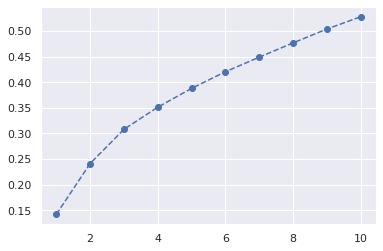

In [6]:
plt.plot(range(1,11), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

In [7]:
def get_pca_scores(data, n_components=3):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    scores_pca = pca.transform(data)
    scores_df = pd.DataFrame(scores_pca, index=data.index)
    return scores_pca, scores_df

In [8]:
scores_pca, scores_df = get_pca_scores(freqs)
scores_df.head()

,0,1,2
DF_p1,40.037988,-3.821383,-42.237920
DF_p2,33.066367,-4.603961,-37.730530
DF_p23,56.750566,12.012073,-51.360492
DF_p24,30.643840,-9.175355,-30.545063
DF_p25,28.898513,-9.816033,-29.512744


<a id='wcss'></a>
## tally Within-Cluster Sum of Squares

[toip](#home)

In [9]:
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++')
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'Within-cluster sum of squares')

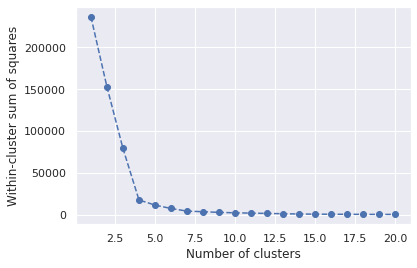

In [10]:
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')

<a id='perf'></a>
## perform k-means clustering on PCA data

[top](#home)

In [11]:
# get kmeans
# use random state so the clusters are named the same each time
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [12]:
f2 = pd.concat([freqs, pd.DataFrame(scores_pca, index=freqs.index)], axis=1)
f2.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
f2['Segment K-means PCA'] = kmeans_pca.labels_
f2['Segment'] = f2['Segment K-means PCA'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth'})
f2.head()

,jcf7190000000000-77738,jcf7190000000000-77764,jcf7190000000004-54418,jcf7190000000004-54508,jcf7190000000004-54540,jcf7190000000004-54587,jcf7190000000004-54589,jcf7190000000004-54643,jcf7190000000004-54644,jcf7190000000004-54700,jcf7190000000004-54857,jcf7190000000004-54872,jcf7190000000004-54939,jcf7190000000004-54956,jcf7190000000004-54984,jcf7190000000004-54991,jcf7190000000004-54998,jcf7190000000004-55010,jcf7190000000004-55035,jcf7190000000004-55083,jcf7190000000004-55107,jcf7190000000004-55162,jcf7190000000004-55205,jcf7190000000004-55206,jcf7190000000004-55210,jcf7190000000004-55256,jcf7190000000004-55269,jcf7190000000004-55345,jcf7190000000004-55503,jcf7190000000004-55528,jcf7190000000004-55573,jcf7190000000004-55714,jcf7190000000004-55840,jcf7190000000004-55975,jcf7190000000004-56095,jcf7190000000004-56101,jcf7190000000004-56179,jcf7190000000004-56230,jcf7190000000004-56265,jcf7190000000004-56338,jcf7190000000004-56444,jcf7190000000004-56472,jcf7190000000004-56722,jcf7190000000004-56739,jcf7190000000004-56754,jcf7190000000004-56815,jcf7190000000004-56841,jcf7190000000004-56844,jcf7190000000004-56856,jcf7190000000004-57312,...,jcf7190016526565-25319,jcf7190016526565-25358,jcf7190016526565-25370,jcf7190016526565-25372,jcf7190016526565-25384,jcf7190016526565-25388,jcf7190016526565-25444,jcf7190016526565-32698,jcf7190016526565-32702,jcf7190016526565-32717,jcf7190016526565-32735,jcf7190016526565-32938,jcf7190016526567-46424,jcf7190016526567-46426,jcf7190016526567-46465,jcf7190016526567-46543,jcf7190016526567-46560,jcf7190016526567-46607,jcf7190016526567-47285,jcf7190016526567-47374,jcf7190016526567-47394,jcf7190016526567-47539,jcf7190016526567-47632,jcf7190016526567-47636,jcf7190016526567-47773,jcf7190016526567-47783,jcf7190016526567-47850,jcf7190016526567-47874,jcf7190016526567-47906,jcf7190016526567-47972,jcf7190016526567-48151,jcf7190016526567-48224,jcf7190016526567-48236,jcf7190016526567-48240,jcf7190016526567-48272,jcf7190016526567-48337,jcf7190016526567-48345,jcf7190016526567-48524,jcf7190016526567-48549,jcf7190016526567-48602,jcf7190016526567-48626,jcf7190016526567-48634,jcf7190016526567-48722,jcf7190016526567-48822,jcf7190016526567-48911,Component 1,Component 2,Component 3,Segment K-means PCA,Segment
DF_p1,0.705900,0.75000,0.2553,0.046200,0.253700,0.0132,0.8667,0.1471,0.2941,0.3205,0.3933,0.040500,0.3333,0.0238,0.105300,0.19440,0.2368,0.25000,0.2571,0.306100,0.29630,0.38600,0.277800,0.259300,0.470600,0.47170,0.2931,0.3953,0.1882,0.3708,0.3100,0.1858,0.2535,0.233800,0.0811,0.0750,0.1048,0.185625,0.4146,0.2917,0.3571,0.4423,0.06150,0.053600,0.054500,0.11110,0.294100,0.7273,0.09680,0.4375,...,0.5556,0.333300,0.529400,0.437500,0.58820,0.58820,1.0000,0.592600,0.5769,0.61110,0.65710,0.708300,0.769200,0.066700,0.341500,0.3387,0.3846,0.27470,0.086700,0.3750,0.3689,0.075200,0.360000,0.34020,0.5098,0.3500,0.3868,0.360000,0.020200,0.036700,0.3137,0.36000,0.25680,0.4054,0.20590,0.38890,0.226700,0.454500,0.4658,0.175825,0.2840,0.2875,0.3621,0.205900,0.470600,40.037988,-3.821383,-42.237920,1,second
DF_p2,0.579825,0.69465,0.4000,0.062500,0.305600,0.0968,0.8387,0.1960,0.3939,0.3571,0.4000,0.000000,0.4000,0.0000,0.279275,0.42745,0.3500,0.36840,0.4000,0.428600,0.40160,0.60000,0.321325,0.341950,0.504825,0.54275,0.3212,0.3600,0.3182,0.3500,0.3889,0.3043,0.5000,0.233525,0.4839,0.4839,0.6071,0.208300,0.4000,0.3308,0.6429,0.5385,0.06535,0.043050,0.026525,0.06375,0.416425,0.8453,0.03890,0.3333,...,0.6250,0.125075,0.484225,0.393650,0.53645,0.54295,0.6364,0.686625,0.6882,0.66225,0.63075,0.688600,0.590175,0.224925,0.433875,0.3200,0.4643,0.20235,0.037000,0.1481,0.1333,0.174675,0.231275,0.22495,0.4706,0.2571,0.2500,0.189075,0.154225,0.152975,0.2692,0.27735,0.23255,0.5000,0.30345,0.33385,0.305825,0.271825,0.2500,0.136775,0.3182,0.3182,0.3043,0.193875,0.502275,33.066367,-4.603961,-37.730530,1,second
DF_p23,0.624950,0.71955,0.2581,0.159100,0.278875,0.2083,0.8913,0.0204,0.3600,0.2745,0.2787,0.142900,0.3750,0.0000,0.090900,0.28070,0.3065,0.32995,

<a id='figs'></a>

# create figures

[top](#home)

In [13]:
coldict = {'first':'blue',
           'second':'green',
           'third':'black',
           'fourth':'magenta',
           'fifth':'yellow'}

<a id='color'></a>
## color-coded PCA figures 

[top](#home)

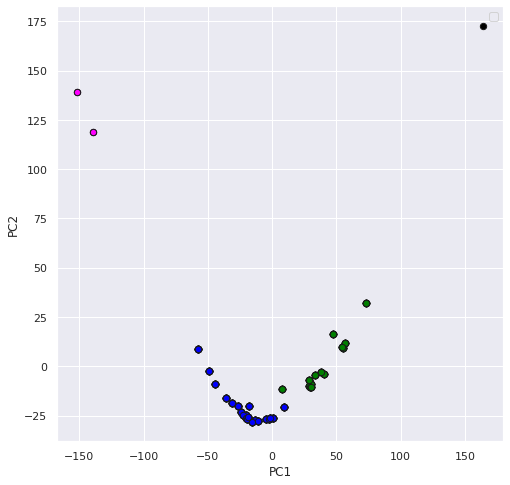

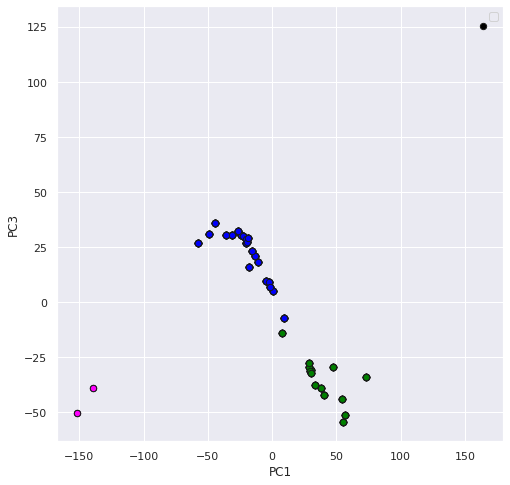

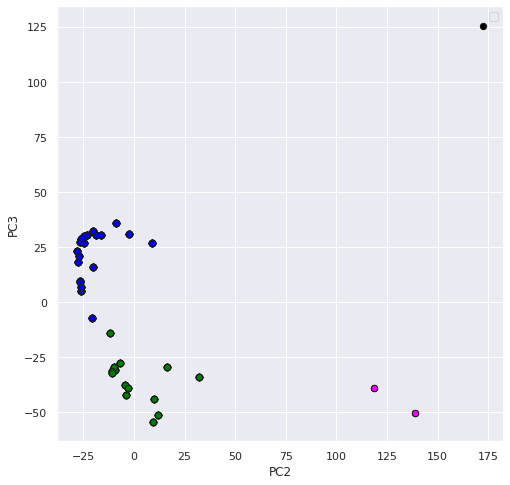

In [14]:
%matplotlib inline
for axes in [[0,1], [0,2], [1,2]]:
    plot_2d_pca(f2, scores_pca, axes=axes)

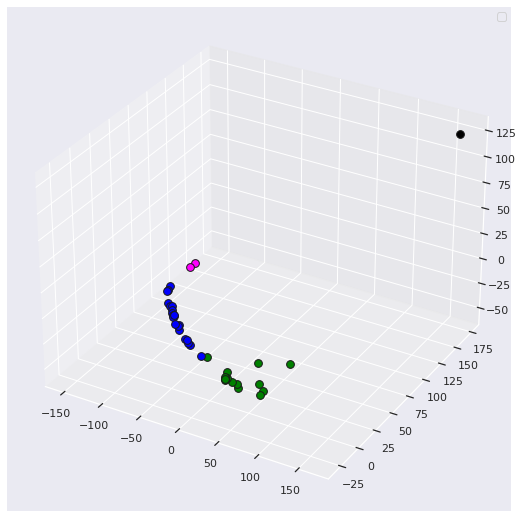

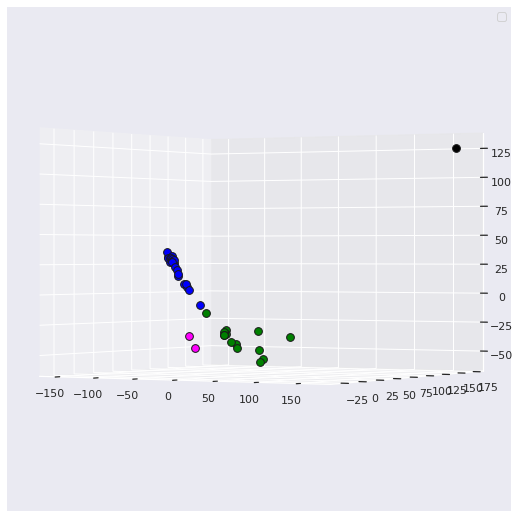

In [15]:
plot_3d(scores_df)
plot_3d(scores_df, elev=0)

In [34]:
# plot rotatable 3D fig
%matplotlib notebook
plot_3d(scores_df, elev=0)

<IPython.core.display.Javascript object>

<a id='nomissing'></a>
## compare to no missing data

[top](#home)

In [17]:
fs('/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/\
03_maf-p05_RD-recalculated_FDC/rda', 'nomissing',
   bnames=True)

['DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated_nomissing-loci-list.txt']

In [18]:
rdadir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/coastal_variety_with-p6/\
03_maf-p05_RD-recalculated_FDC/rda'
nomissinglocidf = pd.read_table(op.join(rdadir, 'DF_pooled-varscan_all_bedfiles_SNP_FDC_maf_RD-recalculated_nomissing-loci-list.txt'))
nomissingloci = nomissinglocidf['no_missing_loci'].tolist()
len(nomissingloci)

501830

In [19]:
ncol(freqs)

2254116

In [20]:
nomissingfreqs = freqs[nomissingloci]
nomissingfreqs.shape

(38, 501830)

In [21]:
nm_scores,nm_scoresdf = get_pca_scores(nomissingfreqs)

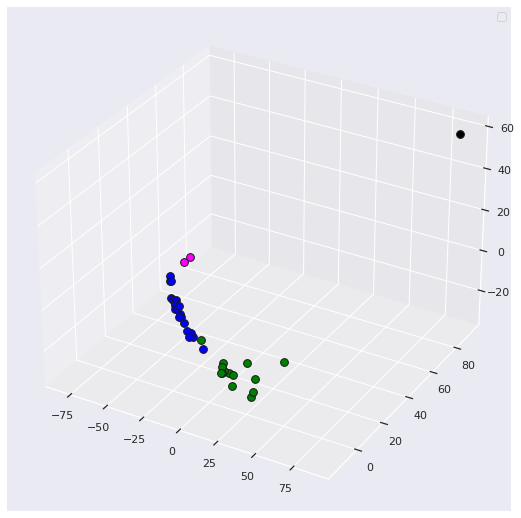

In [22]:
%matplotlib inline
plot_3d(nm_scoresdf)

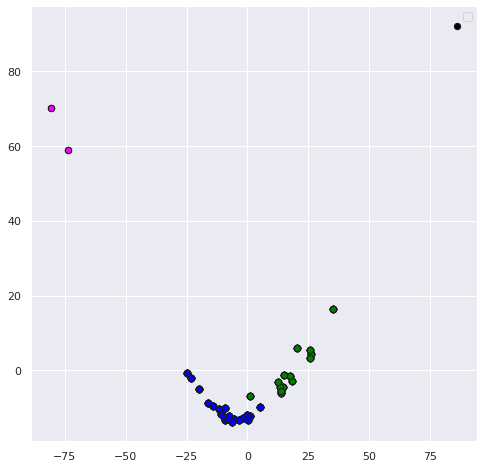

In [23]:
bl = plot_2d_pca(f2, nm_scores)

<a id='maps'></a>
# plot on a map

[top](#home)

In [24]:
from mymaps import *

In [25]:
# read in envdata for popID->lat/long
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_coastal-naturalpops_std_env-19variables_change-p6.txt')
envdata.index = envdata['our_id'].tolist()
envdata.head()

,prov,our_id,Variety,LONG,LAT,Elevation,MAT,MWMT,MCMT,TD,MAP,MSP,AHM,SHM,DD_0,DD5,NFFD,bFFP,eFFP,FFP,PAS,EMT,EXT,Eref,CMD
DF_p1,1,DF_p1,FDC,-126.63,49.78,225,0.033205,-0.548835,0.543651,-0.997331,2.328792,2.609691,-1.091101,-0.811441,-0.545596,-0.324814,0.662851,-0.649675,0.433261,0.573164,0.004594,0.778311,-0.895826,-0.829706,-1.368839
DF_p2,2,DF_p2,FDC,-122.73,50.32,550,-1.041644,-0.199785,-1.629247,1.540520,-1.056228,-0.569995,0.536594,-0.106479,1.725063,-0.581350,-1.054536,0.324197,-1.278041,-0.779474,0.419775,-1.445170,-0.170729,-0.522306,0.134393
DF_p6,6,DF_p6,FDC,-125.75,52.28,460,-1.508969,-0.461573,-2.569755,2.352632,-1.286068,-0.828740,0.921322,0.090378,3.075349,-0.750289,-1.741491,1.005907,-2.163197,-1.580016,0.518853,-2.768670,-0.247055,-0.475906,0.564611
DF_p10,10,DF_p10,FDC,-125.33,50.00,152,-0.013528,-0.112523,0.089613,-0.185219,-0.518038,-0.133004,0.033488,-0.345900,-0.309447,-0.151704,0.388069,-0.600981,0.020188,0.352325,-0.533255,0.390084,-0.323381,-0.568706,-0.447666
DF_p11,11,DF_p11,FDC,-123.97,48.95,732,-1.181842,-1.072411,-0.559014,-0.252895,0.280713,-0.133004,-0.706373,-0.440339,0.623037,-1.244590,-0.527871,0.226810,-0.451895,-0.337796,1.443575,-0.245196,-1.201130,-1.276306,-0.665306


In [26]:
# first assign colors by kmeans cluster
popcolors = dict(zip(f2.index, f2['Segment'].map(coldict)))
popcolors['DF_p12']

'black'

In [27]:
?basemap

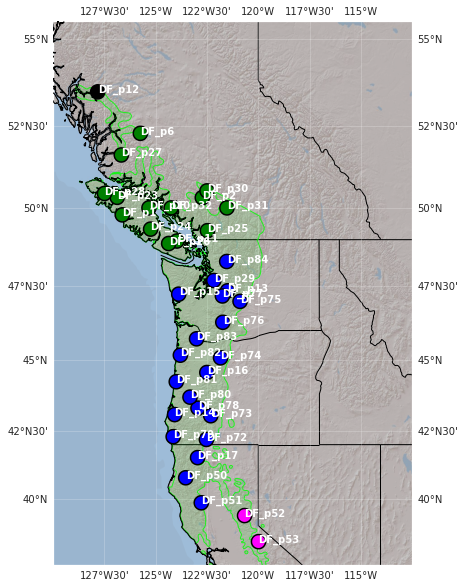

In [28]:
# use kmeans colors
coastrange = '/data/projects/pool_seq/environemental_data/shapefiles/Coastal_DF.shp'
df_shapfiles = [('lime', coastrange)]
extent=[-130, -112.5, 37.5, 55.5]
ax = basemap(extent, figsize=(15,10), shapefiles=df_shapfiles)

for pop in envdata.index:
    long,lat = envdata.loc[pop, ['LONG', 'LAT']]
    draw_pie_marker([1,0],
                    long,
                    lat,
                    200,
                    ax=ax,
                    colors=[popcolors[pop]],
                    label=pop,
                    zorder=1000,
                    transform=True)
plt.show()

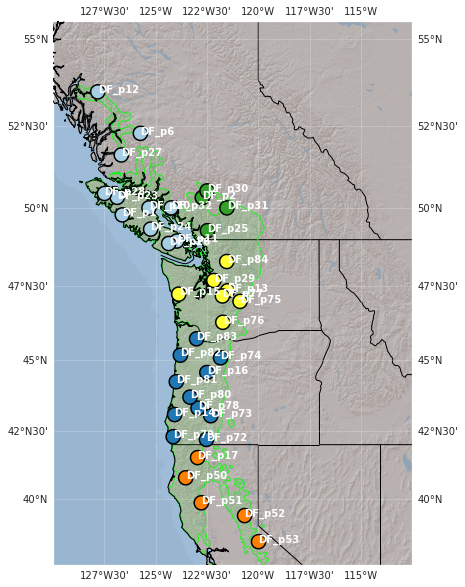

In [29]:
# use geography for pop colors
popcols = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/doug-fir_colored_pops.txt')
popcolors = dict(zip(popcols['our_id'], popcols['group_color']))

ax = basemap(extent, figsize=(15,10), shapefiles=df_shapfiles)

for pop in envdata.index:
    long,lat = envdata.loc[pop, ['LONG', 'LAT']]
    draw_pie_marker([1,0],
                    long,
                    lat,
                    200,
                    ax=ax,
                    colors=[popcolors[pop]],
                    label=pop,
                    zorder=1000,
                    transform=True)
plt.show()

In [30]:
# color->pop mapping
rev_popcolors = defaultdict(list)
for pop,color in popcolors.items():
    rev_popcolors[color].append(pop)
rev_popcolors = dict(rev_popcolors)
rev_popcolors

{'#a6cee3': ['DF_p1',
  'DF_p6',
  'DF_p10',
  'DF_p11',
  'DF_p12',
  'DF_p23',
  'DF_p24',
  'DF_p26',
  'DF_p27',
  'DF_p28',
  'DF_p32'],
 '#33a02c': ['DF_p2', 'DF_p25', 'DF_p30', 'DF_p31'],
 '#22ff00': ['DF_p3', 'DF_p33', 'DF_p34', 'DF_p37', 'DF_p46', 'DF_p47'],
 '#f205f4': ['DF_p4',
  'DF_p7',
  'DF_p8',
  'DF_p9',
  'DF_p35',
  'DF_p36',
  'DF_p38',
  'DF_p39',
  'DF_p41',
  'DF_p42',
  'DF_p48'],
 '#995bbe': ['DF_p5',
  'DF_p18',
  'DF_p19',
  'DF_p54',
  'DF_p55',
  'DF_p56',
  'DF_p59',
  'DF_p60',
  'DF_p61'],
 '#ffff33': ['DF_p13',
  'DF_p15',
  'DF_p29',
  'DF_p75',
  'DF_p76',
  'DF_p77',
  'DF_p84'],
 '#1f78b4': ['DF_p14',
  'DF_p16',
  'DF_p72',
  'DF_p73',
  'DF_p74',
  'DF_p78',
  'DF_p79',
  'DF_p80',
  'DF_p81',
  'DF_p82',
  'DF_p83'],
 '#ff7f00': ['DF_p17', 'DF_p50', 'DF_p51', 'DF_p52', 'DF_p53'],
 '#00ecff': ['DF_p20', 'DF_p57', 'DF_p58', 'DF_p62'],
 '#060606': ['DF_p40'],
 '#e31a1c': ['DF_p43', 'DF_p44', 'DF_p45', 'DF_p49']}

In [31]:
for color in rev_popcolors.keys():
    print(ColorText(color).custom(color))

#a6cee3
#33a02c
#22ff00
#f205f4
#995bbe
#ffff33
#1f78b4
#ff7f00
#00ecff
#060606
#e31a1c


In [32]:
# colorgroup
colorgroup = dict(zip(keys(rev_popcolors), ['Western BC', 'Lower Mainland', 'Eastern BC', 'Northern BC', 'Tri-state', 'Washington', 'Oregon', 'California',
 'Montana', 'DF_p40', 'South Central BC']))
rev_colorgroup = dict(zip(['Western BC', 'Lower Mainland', 'Eastern BC', 'Northern BC', 'Tri-state', 'Washington', 'Oregon', 'California',
 'Montana', 'DF_p40', 'South Central BC'], keys(rev_popcolors)))

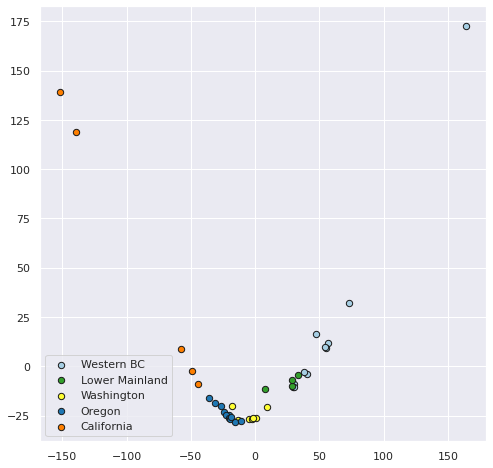

In [33]:
plt.figure(figsize=(8,8))
for group,color in rev_colorgroup.items():
    bools = f2.index.isin(rev_popcolors[color])
    if sum(bools) > 0:
        df = scores_pca[bools]
        plt.scatter(df[:, 0],
                    df[:, 1],
                    label=group, c=color, edgecolor='k', s=40)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(handles, labels)
plt.show()